# Phase2Pro - Iteration 3

In [ ]:
![frontpagehouse.jpg](attachment:frontpagehouse.jpg)

In [41]:
#Import packages
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import scipy.stats as stats
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import random
import math 
import logging
plt.style.use('seaborn')

In [10]:
#Import data set
df = pd.read_csv('data\\kc_house_data.csv')
#refined dataset and drop unnecessary column data
df.drop(['id', 'date', 'waterfront', 'sqft_above', 'sqft_basement', 'lat', 'long', 'view', 'sqft_living15', 'sqft_lot15', 'waterfront', 'yr_renovated'], axis=1, inplace=True)
#incorporated lamda to reduce exponential value occurence in describe data below ()
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if int(x) == x else '{:,.2f}'.format(x) 

In [12]:
#display if any numm values exist in dataset
df.isnull().sum()


price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
condition      0
grade          0
yr_built       0
zipcode        0
dtype: int64

In [13]:
#create the column data
continuous = ['price', 'bedrooms', 'bathrooms', 'grade']
categoricals = ['sqft_living', 'sqft_lot', 'yr_built', 'zipcode', 'floors', 'condition']
df_cont = df[continuous]

In [14]:
# log features
log_names = [f'{column}_log' for column in df_cont.columns]
df_log = np.log(df_cont)
df_log.columns = log_names

In [57]:
#correcting datatypes and describing without exponential ramifications
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if int(x) == x else '{:,.2f}'.format(x) 
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597,21597,21597,21597,21597,21597,21597,19221,21534,21597,21597,21597,21597,17755,21597,21597,21597,21597,21597
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"
std,"2,876,735,715.75","367,368.14",0.93,0.77,918.11,"41,412.64",0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,"27,274.44"
min,1000102,78000,1,0.50,370,520,1,0,0,1,3,370,1900,0,98001,47.16,-122.52,399,651
25%,2123049175,322000,3,1.75,1430,5040,1,0,0,3,7,1190,1951,0,98033,47.47,-122.33,1490,5100
50%,3904930410,450000,3,2.25,1910,7618,1.50,0,0,3,7,1560,1975,0,98065,47.57,-122.23,1840,7620
75%,7308900490,645000,4,2.50,2550,10685,2,0,0,4,8,2210,1997,0,98118,47.68,-122.12,2360,10083
max,9900000190,7700000,33,8,13540,1651359,3.50,1,4,5,13,9410,2015,2015,98199,47.78,-121.31,6210,871200


In [16]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
df_log_norm = df_log.apply(normalize)

In [17]:
# one hot encode categoricals
df_ohe = pd.get_dummies(df[categoricals], prefix=categoricals[0], drop_first=True)
preprocessed = pd.concat([df_log_norm, df_ohe], axis=1)
X = preprocessed.drop('sqft_living', axis=1)
y = preprocessed['sqft_living']

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [20]:
# A brief preview of train-test split to create test training data and dummy data set
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [21]:
#apply model to the train set 
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [22]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test
test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

216438.86075135175

In [ ]:
#Equation displaying the details 

In [23]:
# Force data as pandas DataFrame
def kfolds(data, k):
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size          
    return folds 

In [24]:
df_data = pd.concat([X.reset_index(drop=True), y], axis=1)

In [25]:
df_folds = kfolds(df_data, 5)

In [26]:
test_errs = []
train_errs = []
k=5
for n in range(k):
    # Split in train and test for the fold
    train = pd.concat([fold for i, fold in enumerate(df_folds) if i!=n])
    test = df_folds[n]
    # Fit a linear regression model
    linreg.fit(X_train, y_train)
    #Evaluate Train and Test Errors
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    train_errs.append(np.mean(train_residuals.astype(float)**2))
    test_errs.append(np.mean(test_residuals.astype(float)**2))
print(train_errs)
print(test_errs)

[224969.029589723, 224969.029589723, 224969.029589723, 224969.029589723, 224969.029589723]
[216438.86075135192, 216438.86075135192, 216438.86075135192, 216438.86075135192, 216438.86075135192]


In [27]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [28]:
cv_5_results.mean()

226852.97450995035

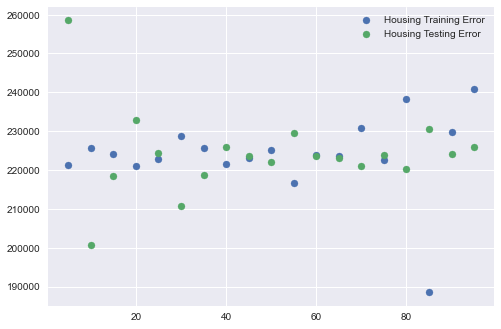

In [33]:
import random
random.seed(110)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Housing Training Error')
plt.scatter(t_sizes, test_err, label='Housing Testing Error')
plt.legend()

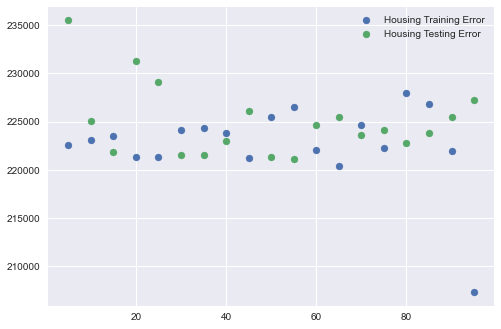

In [32]:
# Your code here
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Housing Training Error')
plt.scatter(t_sizes, test_err, label='Housing Testing Error')
plt.legend()

Null hypothesis:
There is no difference between experimental and control group 
𝜇1=𝜇2μ1=μ2

Alternative Hypothesis:
There is a difference between experimental and control group 
𝜇1≠𝜇2μ1≠μ2


In [36]:
#Paired sample t-test (although data set is over 30)

df = pd.read_csv('data\\kc_house_data.csv')
df[['price','sqft_living']].describe()
ttest,pval = stats.ttest_rel(df['price'], df['sqft_living'])
print(pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

0.0
reject null hypothesis


In [37]:
#create the column data
continuous = ['price', 'bedrooms', 'bathrooms', 'grade']
categoricals = ['sqft_living', 'sqft_lot', 'yr_built', 'zipcode', 'floors', 'condition']
df_cont = df[continuous]

In [38]:
# log features
log_names = [f'{column}_log' for column in df_cont.columns]
df_log = np.log(df_cont)
df_log.columns = log_names

In [39]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
df_log_norm = df_log.apply(normalize)

In [40]:
# one hot encode categoricals with dummy categoricals
df_ohe = pd.get_dummies(df[categoricals], prefix=categoricals[0], drop_first=True)
preprocessed = pd.concat([df_log_norm, df_ohe], axis=1)
X = preprocessed.drop('sqft_living', axis=1)
y = preprocessed['sqft_living']

In [60]:
#from sklearn.model_selection import train_test_split

In [42]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [43]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [62]:
#from sklearn.linear_model import LinearRegression

In [44]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [45]:
test_residuals = y_hat_test - y_test
test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

223302.7402370209

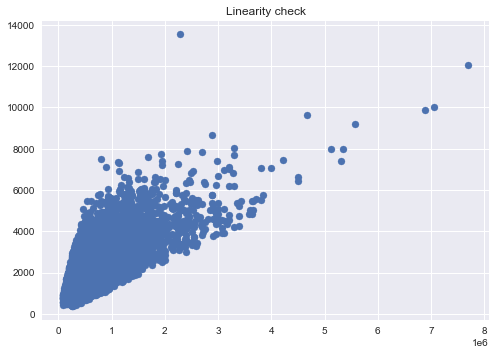

In [46]:
#create a scatter plot to check linearity
plt.scatter(df.price, df.sqft_living)
plt.title("Linearity check")
plt.show()


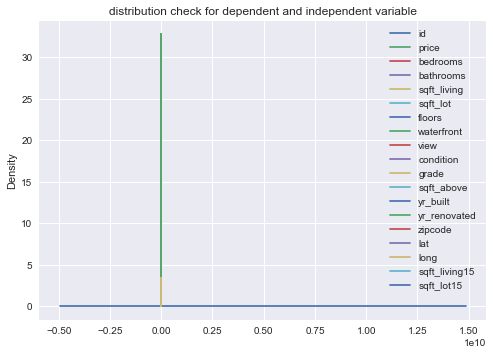

In [48]:
#kernal density plot estimation and distro check
df.plot.kde()
plt.title("distribution check for dependent and independent variable")
plt.show()

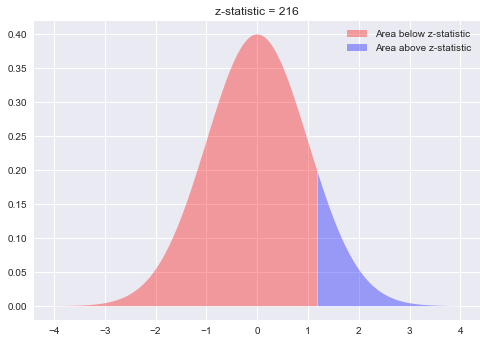

In [54]:
plt.fill_between(x=np.arange(-4,1.19,0.01),
                 y1= stats.norm.pdf(np.arange(-4,1.19,0.01)) ,
                 facecolor='red',
                 alpha=0.35,
                 label= 'Area below z-statistic'
                 )

plt.fill_between(x=np.arange(1.19,4,0.01), 
                 y1= stats.norm.pdf(np.arange(1.19,4,0.01)) ,
                 facecolor='blue',
                 alpha=0.35, 
                 label= 'Area above z-statistic')
plt.legend()
plt.title ('z-statistic = 216');

In [53]:
#Calculate p-value 
stats.norm.cdf(216)

1.0

In [55]:
#display pval with degree of freedon
pval = 1 - stats.norm.cdf(216)
pval

0.0

In [58]:
#clean data review 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900,3,1,1180,5650,1,NaN,0,...,7,1180,0.0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400.0,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000,2,1,770,10000,1,0,0,...,6,770,0.0,1933,NaN,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000,4,3,1960,5000,1,0,0,...,7,1050,910.0,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000,3,2,1680,8080,1,0,0,...,8,1680,0.0,1987,0,98074,47.62,-122.05,1800,7503


In [59]:
df.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

In [60]:
#Enter in code for z test score 
import scipy.stats as stats
from math import sqrt
x_bar = 540296 # sample mean 
n =  21597# number of count
sigma = 367368 # sd of population
mu = 25 # Population mean 
z = (x_bar - mu)/(sigma/sqrt(n))
z

216.12601549430946

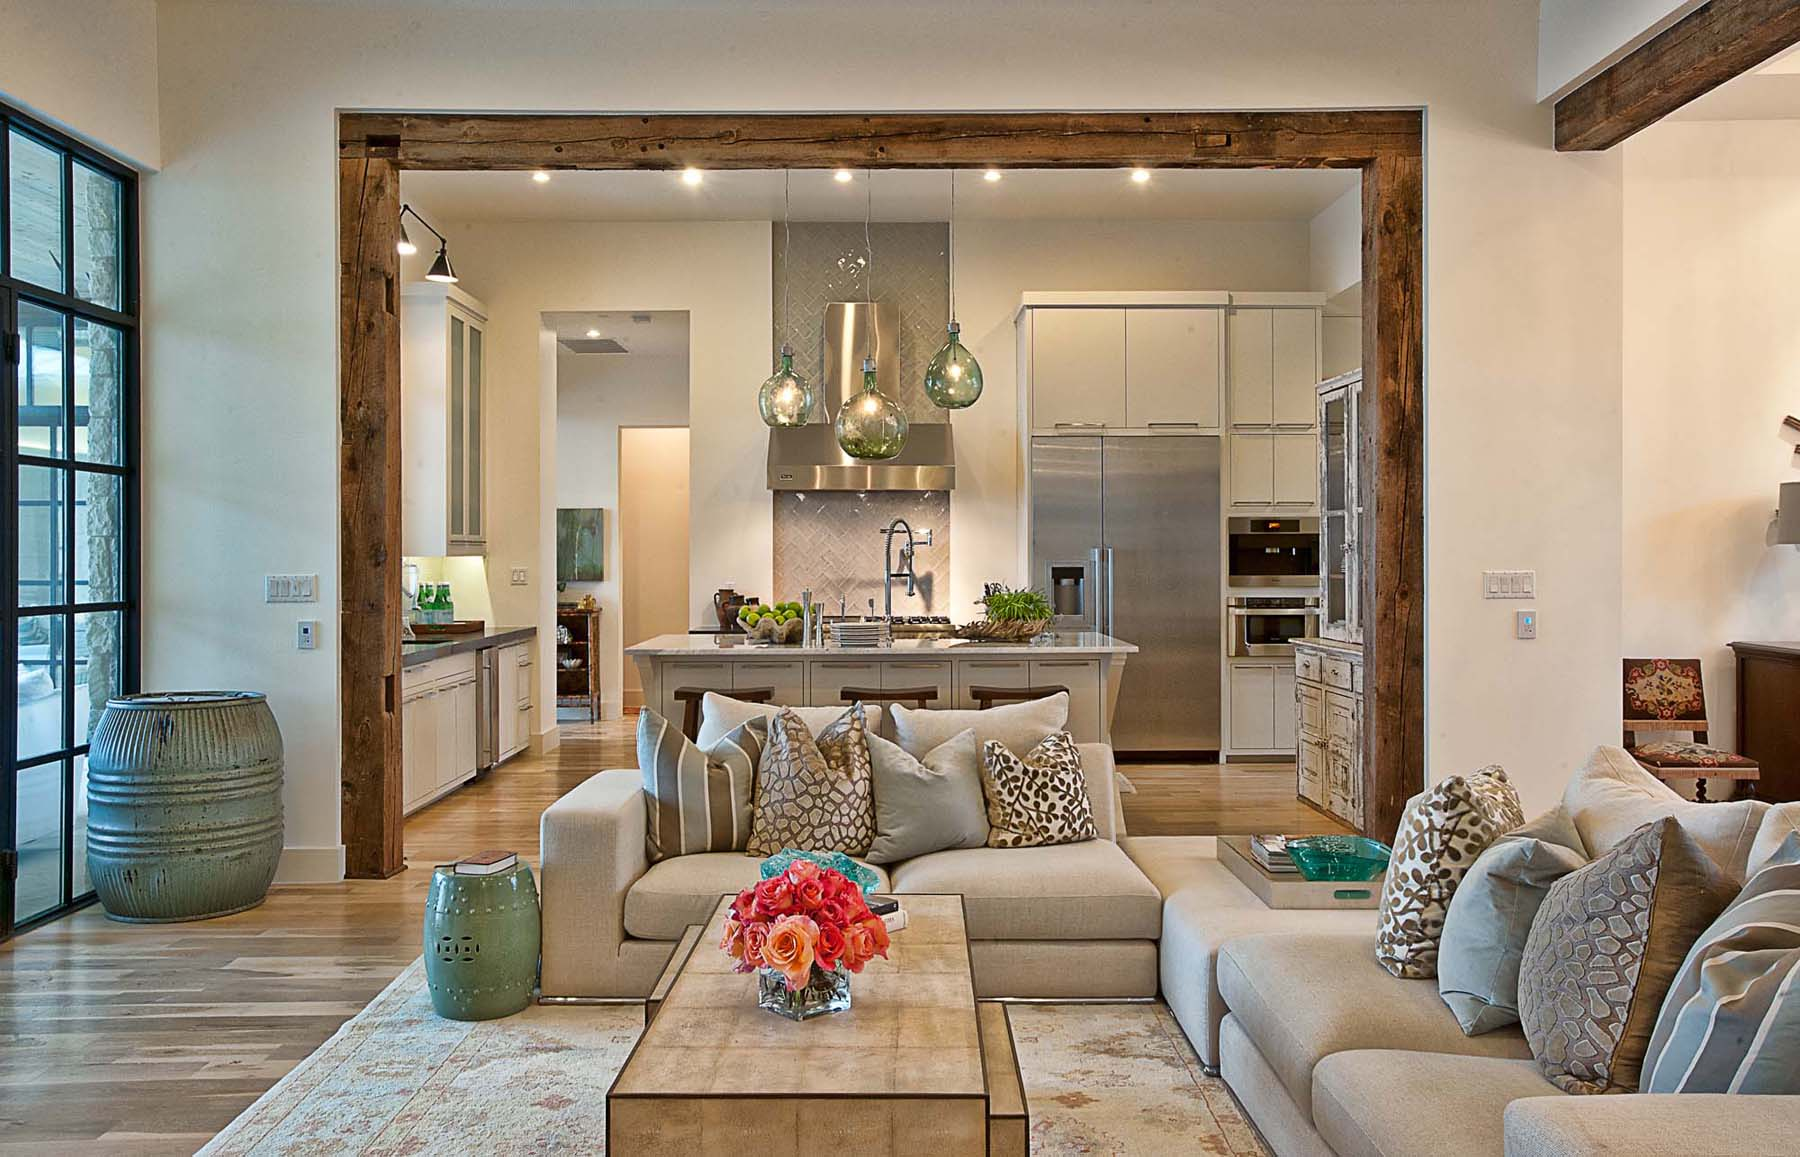

In [35]:
#Note that the bedrooms, grade, sqft_lot are variables that remain closest to our alpha values. 

In [61]:
#creating the variable called model ; to create the best line of fit - we are passing the regression 
#Y is our dependant variable #X is independent variable 
f = 'price~sqft_living'
model = ols(formula=f, data=df).fit()
#prompt for mod summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        21:43:05   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the R squared value is between 0  and 1 with a value of 0.493. This is a great sign that the "sqft_living" coefficient has a strong relationship to sale price. This info will add value to further research regarding understanding the relationships connecting Kings County homebuyers' requirements of buying a property. 

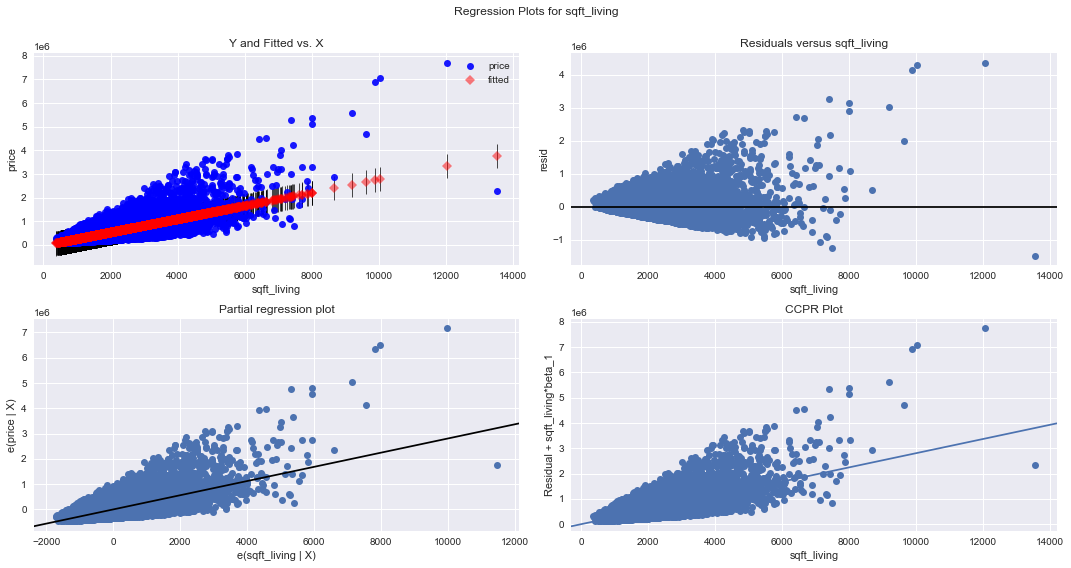

In [62]:
#visualisation 
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

C:\Users\racar\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\racar\AppData\Local\Temp/ipykernel_20404/2992656137.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


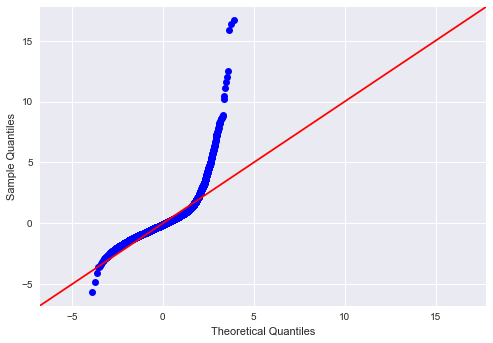

In [63]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

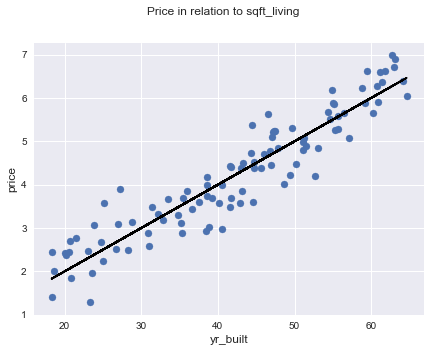

In [64]:
#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)
sen = np.random.uniform(18, 65, 100)
income = np.random.normal((sen/10), 0.5)
sen = sen.reshape(-1, 1)

fig = plt.figure(figsize=(7, 5))
fig.suptitle('Price in relation to sqft_living', fontsize=12)
plt.scatter(sen, income)
plt.plot(sen, sen/10, c='black')
plt.xlabel('yr_built', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [65]:
#
data_pred = df.iloc[:,0:12]
data_pred.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade
0,7129300520,10/13/2014,221900,3,1,1180,5650,1,NaN,0,3,7
1,6414100192,12/9/2014,538000,3,2.25,2570,7242,2,0,0,3,7
2,5631500400,2/25/2015,180000,2,1,770,10000,1,0,0,3,6
3,2487200875,12/9/2014,604000,4,3,1960,5000,1,0,0,5,7
4,1954400510,2/18/2015,510000,3,2,1680,8080,1,0,0,3,8


In [66]:
#
data_pred.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade
id,1,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01
price,-0.02,1,0.31,0.53,0.70,0.09,0.26,0.28,0.40,0.04,0.67
bedrooms,0.00,0.31,1,0.51,0.58,0.03,0.18,-0.00,0.08,0.03,0.36
bathrooms,0.01,0.53,0.51,1,0.76,0.09,0.50,0.07,0.19,-0.13,0.67
sqft_living,-0.01,0.70,0.58,0.76,1,0.17,0.35,0.11,0.28,-0.06,0.76
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1,-0.00,0.02,0.08,-0.01,0.11
floors,0.02,0.26,0.18,0.50,0.35,-0.00,1,0.02,0.03,-0.26,0.46
waterfront,-0.00,0.28,-0.00,0.07,0.11,0.02,0.02,1,0.41,0.02,0.09
view,0.01,0.40,0.08,0.19,0.28,0.08,0.03,0.41,1,0.05,0.25
condition,-0.02,0.04,0.03,-0.13,-0.06,-0.01,-0.26,0.02,0.05,1,-0.15


In [67]:
#
abs(data_pred.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade
id,True,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True
sqft_lot,False,False,False,False,False,True,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False
condition,False,False,False,False,False,False,False,False,False,True,False


In [69]:
#Cleaning data 
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous
df.drop_duplicates(inplace=True)

In [70]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(grade, sqft_living)",0.76
"(sqft_living, bathrooms)",0.76


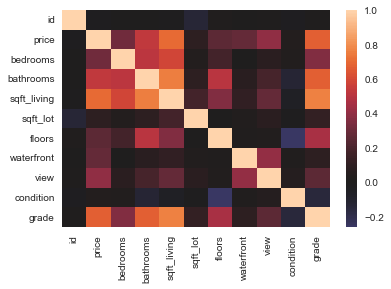

In [72]:
import seaborn as sns
sns.heatmap(data_pred.corr(), center=0);

Each square shows the correlation between the variables on each axis. Correlation ranges from -2 to +1. Data closer to zero means there is no linear relationship between the two variables.

pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));
from statsmodels.formula.api import ols
outcome = 'housing'
x_cols = ['sqft_living', 'grade', 'bathrooms']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()


In [73]:
#List predictions here 
from sklearn.linear_model import LinearRegression

# y = x + 1
X = [[1],[2],[3],[4],[5]]
y = [2, 3, 4, 5, 6]

model = LinearRegression()
model.fit(X, y)

print(f"Fitted model is y = {model.coef_[0]}x + {model.intercept_}")

Fitted model is y = 1.0000000000000002x + 0.9999999999999991


In [2]:
model.predict([[7], [8], [9]])

array([ 8.,  9., 10.])

In [4]:
import joblib

In [5]:
with open('regression_model.pkl', 'wb') as f:
    joblib.dump(model, f)

In [6]:
try:
    print(model.predict([[10], [11], [12]]))
except NameError as e:
    print(type(e), e)

[11. 12. 13.]


In [7]:
import joblib
with open('regression_model.pkl', 'rb') as f:
    model2 = joblib.load(f)
    
print(f"Loaded model is y = {model2.coef_[0]}x + {model2.intercept_}")

Loaded model is y = 1.0000000000000002x + 0.9999999999999991


In [8]:
model2.predict([[10], [11], [12]])

array([11., 12., 13.])